(C) Gerold Baier, University College London, 2024

# Oscillations in Two Coupled Variables



## Mathematical Model

Single Variable, first-order differential equation

The equation:

$$ \frac{dEx}{dt} = h_{ex} - Ex + c_1*tanh(Ex) - c_2*tanh(In) $$
$$ \frac{dIn}{dt} = h_{in} - In + c_3*tanh(Ex) - c_4*tanh(In) $$

where $Ex$ and $In$ are variables that changes with time $t$, $h_{ex}$ and $c_i$ are model parameters, _tanh_ is the tangens hyperbolicus.

The model dynamics can be characterised by scans of parameter h_ex.

Note that for $c_2 = c_3 = 0$, the two variables are uncoupled and independent. We want to study the interaction between the two variables as a function of one of the coupling parameters, $c_2$.


## Import Functions

In [1]:
from scipy.integrate import odeint
from scipy.signal import find_peaks

from numpy import zeros, ones, tanh, mod, gradient, linspace, sign, log, meshgrid 
from numpy import sqrt, fill_diagonal, ndarray, amax, amin, where
from numpy import asarray, array, around, arange, corrcoef, flip, var
from numpy.random import uniform, normal, seed

from matplotlib.pyplot import subplots, xticks, yticks, axes


## Model and Functions

In [2]:
def sigmoid(u):
    
    return tanh(u)

def N_oscillators(y, t, h_ex, h_in, pars):

    tau_ex, tau_in, c_1, c_2, c_3, c_4 = pars

    dydt = (
        (h_ex - y[0] + c_1*sigmoid(y[0]) - c_2*sigmoid(y[1]))*tau_ex,
        (h_in - y[1] + c_3*sigmoid(y[0]) - c_4*sigmoid(y[1]))*tau_in,
       )

    return dydt


In [3]:
def plot_series(time, data, time_begin, time_end, sr):
    
    N = data.shape[1]//2
    
    name_vars = ('Ex', 'In')

    no_vars = 2*N

    fig, ax = subplots(ncols=2*N, figsize=(6, 4))

    for ind in arange(no_vars):

        ax[ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, ind], linewidth=2, c='b')
        ax[ind].set_xticks(linspace(0, time_end-time_begin, 5));
        ax[ind].set_xticklabels(linspace(0, time_end-time_begin, 5));
        ax[ind].set_xlabel('Time', fontsize=12);
        ax[ind].set_ylabel(name_vars[ind], fontsize=12)
        y_min, y_max = ax[ind].get_ylim()
        ax[ind].set_yticks(linspace(y_min, y_max, 3));
        ax[ind].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);
    
    fig.tight_layout()
    
    return fig, ax


def plot_state_space(time, data, time_begin, time_end, sr):
    
    N = data.shape[1]//2
    
    name_vars = ('Ex', 'In')

    no_vars = 2*N

    fig, ax = subplots(figsize=(6, 4))

    ax.plot(data[time_begin*sr:time_end*sr, 1], data[time_begin*sr:time_end*sr, 0], linewidth=2, c='b')
    # ax.set_xticks(linspace(0, time_end-time_begin, 5));
    # ax.set_xticklabels(linspace(0, time_end-time_begin, 5));
    ax.set_xlabel('In', fontsize=12);
    ax.set_ylabel('Ex', fontsize=12)
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);
    ax.set_xticks(linspace(x_min, x_max, 3));
    ax.set_xticklabels(around(linspace(x_min, x_max, 3),1), fontsize=14);

    fig.tight_layout()
    
    return fig, ax


In [4]:
def run_bif_diagram(time_stop, sr, par_set, h_in, y_ini, pars):

    time = linspace(start=0, stop=time_stop, num=time_stop*sr)
    
    results_max_f      = dict()
    results_max_inds_f = dict()
    results_min_f      = dict()
    results_min_inds_f = dict()
    
    rows = time.size
    
    num = 0
    # Simulation "forward"
    for par in par_set:

        h_ex = par

        y_f = odeint(func=N_oscillators, y0=y_ini, t=time, 
                 args=(h_ex, h_in, pars), 
                 hmax=0.1)
     
        for num, series in enumerate(y_f[rows//2:,:-1:2].T):
                    
            if var(series) < 0.00005:
                
                if num not in results_max_f:
                    
                    results_max_f[num]      = [series[-1]]
                    results_max_inds_f[num] = [0]    
                    results_min_f[num]      = [series[-1]]
                    results_min_inds_f[num] = [0]    
                    
                else:
                    results_max_f[num].append(series[-1])
                    results_max_inds_f[num].append(0)    
                    results_min_f[num].append(series[-1])
                    results_min_inds_f[num].append(0)               
    
    
            else:
                y_f_max_inds = find_peaks(series, distance=100)
                y_f_maxs     = series[y_f_max_inds[0]]
    
                y_f_min_inds = find_peaks(-series, distance=100)
                y_f_mins     = series[y_f_min_inds[0]]
    
                if num not in results_max_f:
    
                    results_max_f[num]      = [y_f_maxs]
                    results_max_inds_f[num] = [y_f_max_inds]
                    results_min_f[num]      = [y_f_mins]    
                    results_min_inds_f[num] = [y_f_min_inds]    
    
                else:
    
                    results_max_f[num].append(y_f_maxs)
                    results_max_inds_f[num].append(y_f_max_inds)
                    results_min_f[num].append(y_f_mins)
                    results_min_inds_f[num].append(y_f_min_inds)
    
        if par != par_set[-1]:
            
            y_ini = y_f[-1, :]
        
    
    results_max_b      = dict()
    results_max_inds_b = dict()
    results_min_b      = dict()
    results_min_inds_b = dict()
    
    
    # Simulation "backward"
    for par in flip(par_set):

        h_ex = par
        
        y_b = odeint(func=N_oscillators, y0=y_ini, t=time, 
                 args=(h_ex, h_in, pars), 
                 hmax=0.1)
    
        for num, series in enumerate(y_b[rows//2:,:-1:2].T):
            
            if var(series) < 0.00005:
                
                if num not in results_max_b:
                    
                    results_max_b[num]      = [series[-1]]
                    results_max_inds_b[num] = [0]    
                    results_min_b[num]      = [series[-1]]
                    results_min_inds_b[num] = [0]    
                    
                else:
                    results_max_b[num].append(series[-1])
                    results_max_inds_b[num].append(0)    
                    results_min_b[num].append(series[-1])
                    results_min_inds_b[num].append(0)               
    
    
            else:
                y_b_max_inds = find_peaks(series, distance=100)
                y_b_maxs     = series[y_b_max_inds[0]]
    
                y_b_min_inds = find_peaks(-series, distance=100)
                y_b_mins     = series[y_b_min_inds[0]]
    
                if num not in results_max_b:
    
                    results_max_b[num]      = [y_b_maxs]
                    results_max_inds_b[num] = [y_b_max_inds]
                    results_min_b[num]      = [y_b_mins]    
                    results_min_inds_b[num] = [y_b_min_inds]    
    
                else:
    
                    results_max_b[num].append(y_b_maxs)
                    results_max_inds_b[num].append(y_b_max_inds)
                    results_min_b[num].append(y_b_mins)
                    results_min_inds_b[num].append(y_b_min_inds)
        
        # y_ini = y_b[-1, :]
    
    return results_min_f, results_max_f, results_min_b, results_max_b


def plot_bifdiagram(results_min_f, results_max_f, 
                    results_min_b, results_max_b,
                    par_set):
    
    N = len(results_min_f)

    fig, ax = subplots()

    for xe, ye in zip(par_set, results_max_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='m', s=50, marker='x')

    for xe, ye in zip(par_set, results_min_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='m', s=50, marker='x')

    for xe, ye in zip(flip(par_set), results_max_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='b', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='P')

    for xe, ye in zip(flip(par_set), results_min_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='b', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='P')

    ax.set_xticks(linspace(par_min, par_max, 5));
    ax.set_xticklabels(around(linspace(par_min, par_max, 5), 2), fontsize=16);
    ax.set_xlabel('Parameter', fontsize=16)

    ax.set_ylabel('Ex', fontsize=14)

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),2), fontsize=14);


    fig.tight_layout()
    
    return fig, ax


## Time Series


In [25]:
# Excitatory input parameter
h_ex_0    = -2.5
h_in_0    = -4

# Supercritical Hopf parameters
pars = (1, 1, 4, 6, 6, 0)
# Bistability parameters
# pars = (1, 1, 4, 1, 6, 0)

# Initial conditions
seed(1108)
y_ini = uniform(size=2)
# y_ini = y[-1, :]

# Time array
time_stop = 10
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

# Simulation
y = odeint(func=N_oscillators, y0=y_ini, t=time, 
          args=(h_ex_0, h_in_0, pars), 
          hmax=0.1)

# Show final values of all variables
print('End of run:', list(around(y[-1,:],3)))
print('')


End of run: [-0.237, -0.502]



Figs/SuperHopf_Timeseries_h_ex-2.5.png


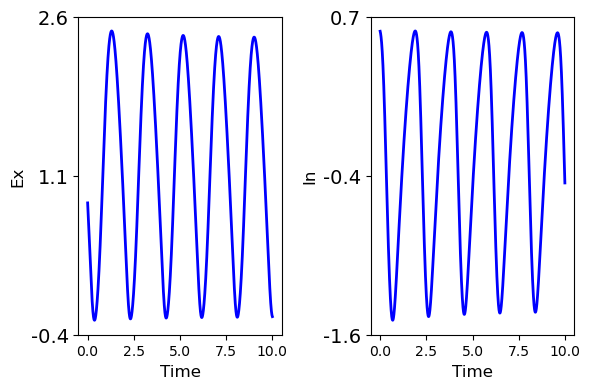

In [26]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series(time, y, time_begin, time_end, sr)

title_chars = 'Figs/SuperHopf_Timeseries_h_ex' + str(h_ex_0) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)


## Bifurcation Diagram

In [35]:
# Initial conditions
y_ini = y[-1, :]

# Bifurcation parameter range
steps = 50
par_min, par_max = -5, 5

par_set = linspace(par_min, par_max, steps)

# Stop time
time_stop = 100

results_min_f, results_max_f, results_min_b, results_max_b = run_bif_diagram(time_stop, sr, par_set, h_in_0, y_ini, pars)

print('Scan complete!')
print('')


Scan complete!



'2Var_Bifs_h_ex, c_2=6.png'

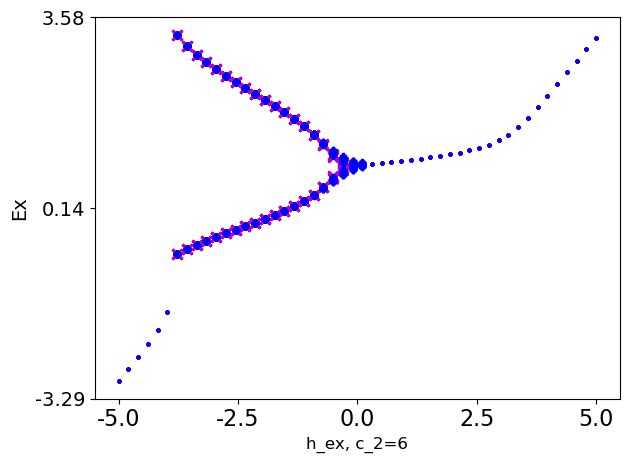

In [36]:
# Plot
fig, ax = plot_bifdiagram(results_min_f, results_max_f, 
                          results_min_b, results_max_b, par_set)


ax.set_xlabel('h_ex, c_2=' + str(pars[3]), fontsize=12)

title_chars = '2Var_Bifs' + '_h_ex, c_2=' + str(pars[3]) + '.png'
# fig.savefig(title_chars, format='png')
title_chars


The result for $c_2 = 6$ involves a SNIC bifurcation (saddle-node on invariant cycle) and a supercritial Hopf bifurcation (real-part of complex pair of eigenvalues of the Jacobian passing through zero). SNIC oscillations are large and slow, Hopf oscillations are sinusoidal and have a characteristic increase in amplitude as the parameter moves away from the bifurcartion point.  

# New Time Series

In [41]:
# Excitatory input parameter
h_ex_0    = -4.05 # Excitable at -4.05, small limit cycle at -0.6
h_in_0    = -4

# Supercritical Hopf parameters
pars = (1, 1, 4, 6, 6, 0)
# Bistability parameters
# pars = (1, 1, 4, 1, 6, 0)

# Initial conditions
seed(1108)
y_ini = uniform(size=2)
# y_ini = y[-1, :]

# Time array
time_stop = 100
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

# Simulation
y = odeint(func=N_oscillators, y0=y_ini, t=time, 
          args=(h_ex_0, h_in_0, pars), 
          hmax=0.1)

# Show final values of all variables
print('End of run:', list(around(y[-1,:],3)))
print('')


End of run: [-1.861, -9.717]



Figs/SuperHopf_Timeseries_h_ex-4.05.png


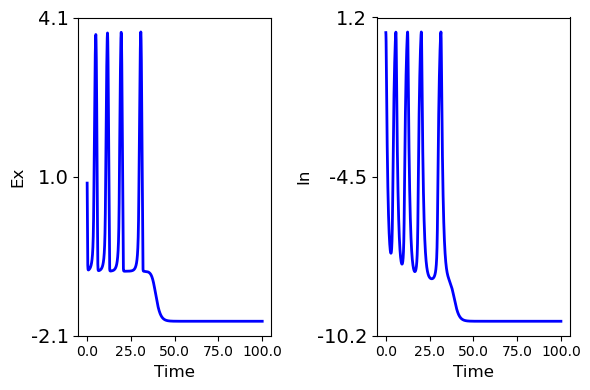

In [42]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series(time, y, time_begin, time_end, sr)

title_chars = 'Figs/SuperHopf_Timeseries_h_ex' + str(h_ex_0) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)


# State Space

Figs/SuperHopf_Timeseries_h_ex-4.05.png


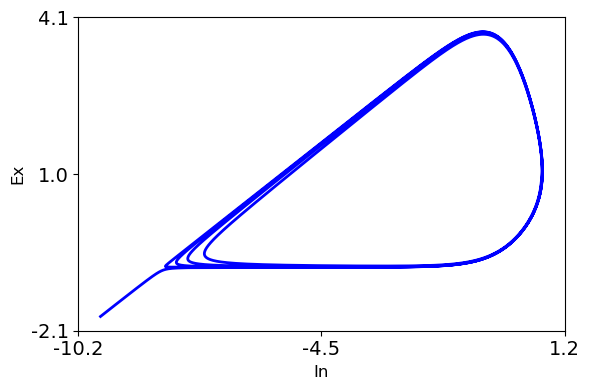

In [43]:
time_begin, time_end = 0, time_stop

fig, ax = plot_state_space(time, y, time_begin, time_end, sr)

title_chars = 'Figs/SuperHopf_Timeseries_h_ex' + str(h_ex_0) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)

# Conclusion

- Coupling between two variables can either retain the bistability (it may exist in any dimension).
- Time-dependent fluctuations are possible with external forcing.
- Amplitude and frequency of oscillations depends on parameter settings.
- As a model of (local) invasive EEG, mesoscopic fluctations self-organise depending on context.


# Try it Yourself

Re-run the above code with these parameter settings:

$pars = (1.2, 0.1, 4, 6, 6, 0)$

Here, the time constants have been made unequal. The excitatory population is now operating at a faster rate compared to the slow population. This leads to a disappearance of the supercritical Hopf bifurcation. 


# Notes on the Reading

## Equilibrium by E. Itzikevich

This tutorial introduces the formal treatment of the concept of __State__ in dynamical systems. It uses linear perturbation theory and shows how states and state transitions can be derived from the eigenvalues of the Jabian matrix of a system of coupled ordinary differential equations. 

A similar treatment can be done on a linearised version of a matrix around a limit cycle. This is the Floquet theory. We can thus expect, oscillatory solutions (as the ones above) to also become unstable and leading to even more complex solutions. 

## The Dynamic Brain: From Spiking Neurons to Neural Masses and Cortical Fields, G Deco et al, and K Friston

This review summarises the reasoning why mesoscopic (large-scale) recordings like the sEEG can be modelled with a comparatively small number of collective variables. This helpt to bypass the need to consider every neuron in the brain or a specific brain area in order to describe the clinical (or experimental) findings. It shows how the mean field approximation is used to derive simple ODE models (page 7, Neural Modes and Masses) which allow a reasonable good description, specifically of pathological findings in the EEG. 

